In [2]:
#import packages
%matplotlib inline  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier

In [20]:
import xgboost as xgt

In [3]:
#data input
data_raw = pd.read_csv("C://Users//95811//Desktop//kagggle//application_train.csv")
data_bureau = pd.read_csv("C://Users//95811//Desktop//kagggle//bureau.csv")
data_credit_card_balance = pd.read_csv("C://Users//95811//Desktop//kagggle//credit_card_balance.csv")
data_previous_application = pd.read_csv("C://Users//95811//Desktop//kagggle//previous_application.csv")
data_installments_payments = pd.read_csv("C://Users//95811//Desktop//kagggle//installments_payments.csv")
data_POS_CASH_balance = pd.read_csv("C://Users//95811//Desktop//kagggle//POS_CASH_balance.csv")


In [4]:
data_bureau_agg=data_bureau.groupby(by='SK_ID_CURR').mean()
data_credit_card_balance_agg=data_credit_card_balance.groupby(by='SK_ID_CURR').mean()
data_previous_application_agg=data_previous_application.groupby(by='SK_ID_CURR').mean()
data_installments_payments_agg=data_installments_payments.groupby(by='SK_ID_CURR').mean()
data_POS_CASH_balance_agg=data_POS_CASH_balance.groupby(by='SK_ID_CURR').mean()

In [13]:
data_raw = data_raw.join(data_bureau_agg, how='inner', on='SK_ID_CURR', lsuffix='1', rsuffix='2')                
data_raw = data_raw.join(data_credit_card_balance_agg, how='inner', on='SK_ID_CURR', lsuffix='1', rsuffix='2')    
data_raw = data_raw.join(data_previous_application_agg, how='inner', on='SK_ID_CURR', lsuffix='1', rsuffix='2')   
data_raw = data_raw.join(data_installments_payments_agg, how='inner', on='SK_ID_CURR', lsuffix='1', rsuffix='2') 

In [5]:
#target confirm 
sk_id_curr = data_raw['SK_ID_CURR']
data_raw.drop('SK_ID_CURR',axis=1,inplace=True)

In [6]:
data_raw

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,1,Cash loans,M,N,Y,0,202500.000,406597.5,24700.5,351000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,Cash loans,F,N,N,0,270000.000,1293502.5,35698.5,1129500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.000,135000.0,6750.0,135000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.000,312682.5,29686.5,297000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,0,Cash loans,M,N,Y,0,121500.000,513000.0,21865.5,513000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,0,99000.000,490495.5,27517.5,454500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0
6,0,Cash loans,F,Y,Y,1,171000.000,1560726.0,41301.0,1395000.0,...,0,0,0,0,0.0,0.0,0.0,1.0,1.0,2.0
7,0,Cash loans,M,Y,Y,0,360000.000,1530000.0,42075.0,1530000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,0,112500.000,1019610.0,33826.5,913500.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
9,0,Revolving loans,M,N,Y,0,135000.000,405000.0,20250.0,405000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
100*(1 - data_raw[data_raw['TARGET']==1].TARGET.count()/data_raw.TARGET.count())

91.92711805431351

In [8]:
categorical_features = data_raw.select_dtypes(include = ["object"]).columns
numerical_features = data_raw.select_dtypes(exclude = ["object"]).columns

print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
data_raw_num = data_raw[numerical_features]
data_raw_cat = data_raw[categorical_features]

Numerical features : 105
Categorical features : 16


In [22]:
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


In [9]:
#one hot encoding
data_raw.replace({'NAME_CONTRACT_TYPE': {'Cash loans': 1, 'Revolving loans': 2}},  inplace = True)
data_raw.replace({'CODE_GENDER': {'M': 1, 'F': 2, 'XNA': 0}},  inplace = True)
data_raw.replace({'FLAG_OWN_CAR': {'Y': 1, 'N': 0}},  inplace = True)
data_raw.replace({'FLAG_OWN_REALTY': {'Y': 1, 'N': 0}},  inplace = True)
data_raw.replace({'NAME_INCOME_TYPE': {'Working': 0, 'State servant': 1, 'Commercial associate': 2,
                                           'Pensioner': 3, 'Unemployed': 4, 'Student': 5, 'Businessman': 6}},  inplace = True)
data_raw.replace({'NAME_EDUCATION_TYPE': {'Secondary / secondary special': 0, 'Higher education': 1, 'Incomplete higher': 2,
                                           'Lower secondary': 3, 'Academic degree': 4}},  inplace = True)
data_raw.replace({'NAME_FAMILY_STATUS': {'Single / not married': 0, 'Married': 1, 'Widow': 2,
                                           'Civil marriage': 3, 'Separated': 4}},  inplace = True)
data_raw.replace({'NAME_HOUSING_TYPE': {'House / apartment': 0, 'Rented apartment': 1, 'Municipal apartment': 2,
                                           'With parents': 3, 'Office apartment': 4, 'Co-op apartment': 5}},  inplace = True)

In [10]:
data_raw = pd.get_dummies(data_raw)

In [11]:
#data cleaning
from sklearn.preprocessing import MinMaxScaler, Imputer
imputer = Imputer(strategy = 'median') # Median imputation of missing values
scaler = MinMaxScaler(feature_range = (0, 1)) # Scale each feature to 0-1

In [12]:
for column in data_raw_num.columns:
    data_raw[[column]] = imputer.fit_transform(data_raw[[column]])
    data_raw[[column]] = scaler.fit_transform(data_raw[[column]])


In [13]:
train=data_raw

In [14]:
X = train.iloc[:,1:]
y = train.iloc[:,0]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("Y_train : " + str(Y_train.shape))
print("Y_test : " + str(Y_test.shape))

X_train : (246008, 230)
X_test : (61503, 230)
Y_train : (246008,)
Y_test : (61503,)


In [ ]:
#rpart
anes1=glm( Y_train~(X_train,family=binomial(link='logit'),data=anesthetic)
summary(anes1)

Call:

glm(formula = nomove ~ conc, family = binomial(link = "logit"), 

    data = anesthetic)

Deviance Residuals: 

     Min        1Q    Median        3Q       Max  

-1.76666  -0.74407   0.03413   0.68666   2.06900  

Coefficients:

                   Estimate Std. Error    z value        Pr(>|z|)   

(Intercept)   -6.469      2.418       -2.675         0.00748 **

conc             5.567      2.044        2.724          0.00645 **

---

Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 41.455  on 29  degrees of freedom

Residual deviance: 27.754  on 28  degrees of freedom

AIC: 31.754

Train/Test split results:
LogisticRegression accuracy is 0.921
LogisticRegression log_loss is 0.247
LogisticRegression auc is 0.745


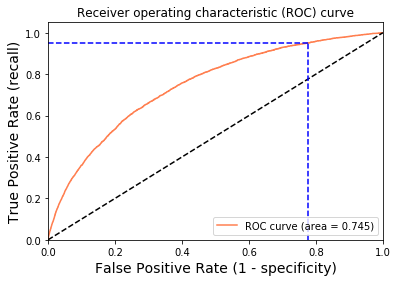

Using a threshold of 0.029 guarantees a sensitivity of 0.950 and a specificity of 0.224, i.e. a false positive rate of 77.61%.


In [33]:
# Logistic Regression result
#python part
logreg = LogisticRegression()


logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

Y_pred_proba = logreg.predict_proba(X_test)[:, 1]
[fpr, tpr, thr] = roc_curve(Y_test, Y_pred_proba)
print('Train/Test split results:')
print(logreg.__class__.__name__+" accuracy is %2.3f" % accuracy_score(Y_test, Y_pred))
print(logreg.__class__.__name__+" log_loss is %2.3f" % log_loss(Y_test, Y_pred_proba))
print(logreg.__class__.__name__+" auc is %2.3f" % auc(fpr, tpr))

idx = np.min(np.where(tpr > 0.95)) # index of the first threshold for which the sensibility > 0.95

plt.figure()
plt.plot(fpr, tpr, color='coral', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,fpr[idx]], [tpr[idx],tpr[idx]], 'k--', color='blue')
plt.plot([fpr[idx],fpr[idx]], [0,tpr[idx]], 'k--', color='blue')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - specificity)', fontsize=14)
plt.ylabel('True Positive Rate (recall)', fontsize=14)
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

print("Using a threshold of %.3f " % thr[idx] + "guarantees a sensitivity of %.3f " % tpr[idx] +  
      "and a specificity of %.3f" % (1-fpr[idx]) + 
      ", i.e. a false positive rate of %.2f%%." % (np.array(fpr[idx])*100))

In [15]:
#lightgbm result
LGB_clf = LGBMClassifier(
    nthread=10,
            n_estimators=10000,
            learning_rate=0.08,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=10,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,)
LGB_clf.fit(X_train, Y_train)
Y_pred_proba = LGB_clf.predict_proba(X_test)[:, 1]

roc_auc_score(Y_test, Y_pred_proba)
#the value is auc

0.7229685232714691

In [18]:
Y_pred_proba

array([0.27010774, 0.01207772, 0.01499362, ..., 0.00579491, 0.0952573 ,
       0.00873975])

In [ ]:
#result of 5 fold cross validation of lightgbm
(356251, 448)
(356251, 448)
Starting LightGBM. Train shape: (307507, 448), test shape: (48744, 448)
Fold  1 AUC : 0.784837
Fold  2 AUC : 0.779759
Fold  3 AUC : 0.781509
Fold  4 AUC : 0.781435
Fold  5 AUC : 0.783746
Full AUC score 0.782242

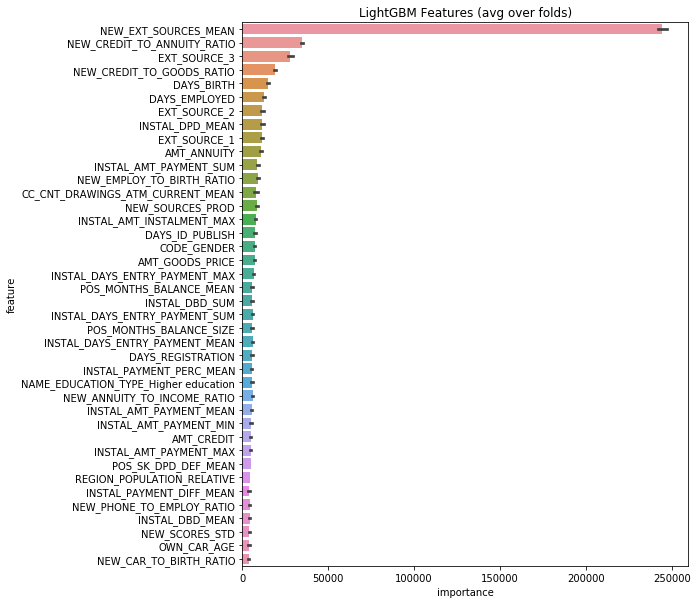

In [21]:
#xgboost result
xgb1 = xgt.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
xgb1.fit(X_train, Y_train)
Y_pred_proba = xgb1.predict_proba(X_test)[:, 1]

roc_auc_score(Y_test, Y_pred_proba)
#the output value is auc

0.7560305162376624

In [ ]:
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785184	valid_1's auc: 0.75891
[200]	training's auc: 0.806842	valid_1's auc: 0.759457
Early stopping, best iteration is:
[135]	training's auc: 0.793517	valid_1's auc: 0.760331
Fold  1 AUC : 0.760331
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785483	valid_1's auc: 0.762992
[200]	training's auc: 0.807378	valid_1's auc: 0.765829
[300]	training's auc: 0.824741	valid_1's auc: 0.766316
[400]	training's auc: 0.839535	valid_1's auc: 0.765697
Early stopping, best iteration is:
[303]	training's auc: 0.825244	valid_1's auc: 0.766462
Fold  2 AUC : 0.766462
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.7852	valid_1's auc: 0.756244
[200]	training's auc: 0.80673	valid_1's auc: 0.758962
[300]	training's auc: 0.824461	valid_1's auc: 0.759304
Early stopping, best iteration is:
[293]	training's auc: 0.823278	valid_1's auc: 0.759548
Fold  3 AUC : 0.759548
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.784854	valid_1's auc: 0.767045
[200]	training's auc: 0.806947	valid_1's auc: 0.767552
Early stopping, best iteration is:
[132]	training's auc: 0.792529	valid_1's auc: 0.768199
Fold  4 AUC : 0.768199
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785087	valid_1's auc: 0.763779
[200]	training's auc: 0.806755	valid_1's auc: 0.76452
Early stopping, best iteration is:
[146]	training's auc: 0.795983	valid_1's auc: 0.764802
Fold  5 AUC : 0.764802
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785573	valid_1's auc: 0.756326
[200]	training's auc: 0.807199	valid_1's auc: 0.756713
[300]	training's auc: 0.824666	valid_1's auc: 0.757504
Early stopping, best iteration is:
[270]	training's auc: 0.819862	valid_1's auc: 0.757828
Fold  6 AUC : 0.757828
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.78527	valid_1's auc: 0.761847
[200]	training's auc: 0.807097	valid_1's auc: 0.763472
Early stopping, best iteration is:
[188]	training's auc: 0.804409	valid_1's auc: 0.763919
Fold  7 AUC : 0.763919
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785417	valid_1's auc: 0.765757
[200]	training's auc: 0.806626	valid_1's auc: 0.766809
Early stopping, best iteration is:
[164]	training's auc: 0.799852	valid_1's auc: 0.767106
Fold  8 AUC : 0.767106
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785195	valid_1's auc: 0.75803
[200]	training's auc: 0.806528	valid_1's auc: 0.758317
[300]	training's auc: 0.823713	valid_1's auc: 0.757131
Early stopping, best iteration is:
[215]	training's auc: 0.809423	valid_1's auc: 0.758962
Fold  9 AUC : 0.758962
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785864	valid_1's auc: 0.749226
[200]	training's auc: 0.807174	valid_1's auc: 0.752121
[300]	training's auc: 0.824723	valid_1's auc: 0.75267
[400]	training's auc: 0.839236	valid_1's auc: 0.751722
Early stopping, best iteration is:
[302]	training's auc: 0.824999	valid_1's auc: 0.752744
Fold 10 AUC : 0.752744
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.786213	valid_1's auc: 0.750851
[200]	training's auc: 0.807085	valid_1's auc: 0.751648
[300]	training's auc: 0.824642	valid_1's auc: 0.751314
Early stopping, best iteration is:
[204]	training's auc: 0.807776	valid_1's auc: 0.75181
Fold 11 AUC : 0.751810
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785513	valid_1's auc: 0.75485
[200]	training's auc: 0.80773	valid_1's auc: 0.757101
[300]	training's auc: 0.824856	valid_1's auc: 0.756904
[400]	training's auc: 0.839602	valid_1's auc: 0.757426
Early stopping, best iteration is:
[371]	training's auc: 0.835657	valid_1's auc: 0.757885
Fold 12 AUC : 0.757885
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.784965	valid_1's auc: 0.75832
[200]	training's auc: 0.80641	valid_1's auc: 0.760435
[300]	training's auc: 0.823544	valid_1's auc: 0.761079
[400]	training's auc: 0.83841	valid_1's auc: 0.761114
Early stopping, best iteration is:
[380]	training's auc: 0.835598	valid_1's auc: 0.761571
Fold 13 AUC : 0.761571
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785931	valid_1's auc: 0.752928
[200]	training's auc: 0.806986	valid_1's auc: 0.755639
[300]	training's auc: 0.824135	valid_1's auc: 0.755519
Early stopping, best iteration is:
[230]	training's auc: 0.812705	valid_1's auc: 0.756383
Fold 14 AUC : 0.756383
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.78451	valid_1's auc: 0.768227
[200]	training's auc: 0.806926	valid_1's auc: 0.769154
[300]	training's auc: 0.824003	valid_1's auc: 0.768746
Early stopping, best iteration is:
[216]	training's auc: 0.80978	valid_1's auc: 0.769604
Fold 15 AUC : 0.769604
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785619	valid_1's auc: 0.753823
[200]	training's auc: 0.806472	valid_1's auc: 0.756299
[300]	training's auc: 0.824298	valid_1's auc: 0.757944
[400]	training's auc: 0.83864	valid_1's auc: 0.757675
Early stopping, best iteration is:
[306]	training's auc: 0.825407	valid_1's auc: 0.758215
Fold 16 AUC : 0.758215
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.78473	valid_1's auc: 0.7587
[200]	training's auc: 0.806632	valid_1's auc: 0.760554
Early stopping, best iteration is:
[163]	training's auc: 0.799304	valid_1's auc: 0.760978
Fold 17 AUC : 0.760978
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.78485	valid_1's auc: 0.773364
[200]	training's auc: 0.806691	valid_1's auc: 0.773596
Early stopping, best iteration is:
[189]	training's auc: 0.804569	valid_1's auc: 0.774206
Fold 18 AUC : 0.774206
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785286	valid_1's auc: 0.760525
[200]	training's auc: 0.806951	valid_1's auc: 0.760361
[300]	training's auc: 0.824257	valid_1's auc: 0.759906
Early stopping, best iteration is:
[249]	training's auc: 0.815984	valid_1's auc: 0.761684
Fold 19 AUC : 0.761684
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.785631	valid_1's auc: 0.750896
[200]	training's auc: 0.807179	valid_1's auc: 0.752633
Early stopping, best iteration is:
[193]	training's auc: 0.805993	valid_1's auc: 0.752886
Fold 20 AUC : 0.752886
Full AUC score 0.761240
C:\Users\95811\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
Out[24]:
feature	importance	fold
0	index	71	1
1	AMT_ANNUITY	221	1
2	AMT_CREDIT	223	1
3	AMT_GOODS_PRICE	207	1
4	AMT_INCOME_TOTAL	43	1
5	AMT_REQ_CREDIT_BUREAU_DAY	1	1
6	AMT_REQ_CREDIT_BUREAU_HOUR	2	1
7	AMT_REQ_CREDIT_BUREAU_MON	11	1
8	AMT_REQ_CREDIT_BUREAU_QRT	42	1
9	AMT_REQ_CREDIT_BUREAU_WEEK	5	1
10	AMT_REQ_CREDIT_BUREAU_YEAR	71	1
11	APARTMENTS_AVG	18	1
12	APARTMENTS_MEDI	13	1
13	APARTMENTS_MODE	22	1
14	BASEMENTAREA_AVG	21	1
15	BASEMENTAREA_MEDI	11	1
16	BASEMENTAREA_MODE	11	1
17	CNT_CHILDREN	9	1
18	CNT_FAM_MEMBERS	5	1
19	CODE_GENDER	69	1
20	COMMONAREA_AVG	13	1
21	COMMONAREA_MEDI	10	1
22	COMMONAREA_MODE	15	1
23	DAYS_BIRTH	247	1
24	DAYS_EMPLOYED	155	1
25	DAYS_ID_PUBLISH	175	1
26	DAYS_LAST_PHONE_CHANGE	110	1
27	DAYS_REGISTRATION	101	1
28	DEF_30_CNT_SOCIAL_CIRCLE	34	1
29	DEF_60_CNT_SOCIAL_CIRCLE	20	1
...	...	...	...
228	ORGANIZATION_TYPE_Trade: type 5	0	20
229	ORGANIZATION_TYPE_Trade: type 6	0	20
230	ORGANIZATION_TYPE_Trade: type 7	0	20
231	ORGANIZATION_TYPE_Transport: type 1	0	20
232	ORGANIZATION_TYPE_Transport: type 2	0	20
233	ORGANIZATION_TYPE_Transport: type 3	14	20
234	ORGANIZATION_TYPE_Transport: type 4	3	20
235	ORGANIZATION_TYPE_University	0	20
236	ORGANIZATION_TYPE_XNA	0	20
237	ORGANIZATION_TYPE_nan	0	20
238	WALLSMATERIAL_MODE_Block	0	20
239	WALLSMATERIAL_MODE_Mixed	0	20
240	WALLSMATERIAL_MODE_Monolithic	0	20
241	WALLSMATERIAL_MODE_Others	2	20
242	WALLSMATERIAL_MODE_Panel	6	20
243	WALLSMATERIAL_MODE_Stone, brick	8	20
244	WALLSMATERIAL_MODE_Wooden	0	20
245	WALLSMATERIAL_MODE_nan	0	20
246	WEEKDAY_APPR_PROCESS_START_FRIDAY	6	20
247	WEEKDAY_APPR_PROCESS_START_MONDAY	14	20
248	WEEKDAY_APPR_PROCESS_START_SATURDAY	8	20
249	WEEKDAY_APPR_PROCESS_START_SUNDAY	10	20
250	WEEKDAY_APPR_PROCESS_START_THURSDAY	1	20
251	WEEKDAY_APPR_PROCESS_START_TUESDAY	14	20
252	WEEKDAY_APPR_PROCESS_START_WEDNESDAY	7	20
253	WEEKDAY_APPR_PROCESS_START_nan	0	20
254	DAYS_EMPLOYED_PERC	183	20
255	INCOME_CREDIT_PERC	148	20
256	INCOME_PER_PERSON	107	20
257	ANNUITY_INCOME_PERC	137	20
5160 rows × 3 columns

In [28]:
X_train

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
307429,0.0,1,2,0,0,0.000000,0.000742,0.163753,0.082380,0.135802,...,0,1,0,0,0,0,0,0,1,0
30132,0.0,1,2,0,0,0.000000,0.000550,0.082478,0.049947,0.070707,...,0,1,0,0,0,0,0,0,1,0
188859,0.0,1,1,1,0,0.000000,0.001320,0.124717,0.056283,0.103255,...,0,0,0,0,0,0,0,0,0,0
225559,0.0,1,2,0,1,0.000000,0.002089,0.192020,0.106687,0.159371,...,0,0,0,0,0,0,0,0,1,0
138524,0.0,1,2,0,1,0.000000,0.001012,0.157303,0.079133,0.158249,...,0,0,0,0,0,1,0,0,1,0
147117,0.0,1,1,1,1,0.000000,0.001127,0.146067,0.111899,0.147026,...,0,0,0,0,0,0,0,0,0,0
240304,1.0,1,2,0,1,0.000000,0.000396,0.038157,0.054282,0.034792,...,0,0,0,0,0,0,0,0,0,0
8672,0.0,1,1,1,1,0.000000,0.000550,0.056669,0.067515,0.052750,...,0,0,0,0,0,0,0,0,0,0
96944,0.0,2,2,0,1,0.000000,0.001166,0.039326,0.033187,0.040404,...,0,0,0,0,0,0,1,0,1,0
273792,0.0,1,1,1,1,0.000000,0.000550,0.325843,0.138996,0.326599,...,0,0,0,0,0,0,0,0,0,0


In [29]:
sk_id_curr = data_raw['SK_ID_CURR']
data_raw.drop('SK_ID_CURR',axis=1,inplace=True)

In [30]:
data_raw

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1.0,1,1,0,1,0.000000,0.001512,0.090287,0.090032,0.077441,...,0,0,0,0,0,0,1,0,1,0
1,0.0,1,2,0,0,0.000000,0.002089,0.311736,0.132924,0.271605,...,0,1,0,0,0,0,0,0,1,0
2,0.0,2,1,1,1,0.000000,0.000358,0.022472,0.020025,0.023569,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1,2,0,1,0.000000,0.000935,0.066837,0.109477,0.063973,...,0,0,0,0,0,0,0,0,0,0
4,0.0,1,1,0,1,0.000000,0.000819,0.116854,0.078975,0.117845,...,0,0,0,0,0,0,0,0,0,0
5,0.0,1,1,0,1,0.000000,0.000627,0.111235,0.101018,0.103255,...,0,0,0,0,0,0,0,0,0,0
6,0.0,1,2,1,1,0.052632,0.001243,0.378458,0.154774,0.337823,...,0,0,0,0,0,0,0,0,0,0
7,0.0,1,1,1,1,0.000000,0.002858,0.370787,0.157792,0.371493,...,0,0,0,0,0,0,0,0,0,0
8,0.0,1,2,0,1,0.000000,0.000742,0.243348,0.125623,0.217733,...,0,0,0,0,0,0,0,0,0,0
9,0.0,2,1,0,1,0.000000,0.000935,0.089888,0.072675,0.090909,...,0,0,0,0,0,0,0,0,0,0


In [1]:
import threading